In [1]:
from sys import path
from os.path import relpath, realpath, abspath, join, exists
from itertools import product

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

pd.set_option('display.max_rows', 999)

In [2]:
from torchnetjson.builder import build_net

In [3]:
from thesis_v2 import dir_dict
from thesis_v2.data import load_data_helper
from thesis_v2.training.training_aux import load_training_results
from thesis_v2.training_extra.misc import count_params
from thesis_v2.models.maskcnn_polished.builder import load_modules

load_modules()

In [4]:
folder_to_check = 'scripts/training/yuanyuan_8k_a_3day/maskcnn_polished'
path.insert(0, join(dir_dict['root'], folder_to_check))
from submit import param_iterator_obj
from key_utils import keygen

In [5]:
def load_everything():
    _df_collect = []
    for idx, param in enumerate(param_iterator_obj.generate()):
        if idx % 50 == 0:
            print(idx)
        
        assert len(param) == 16
#         assert param['split_seed'] == 'legacy'
        assert param['out_channel'] == 16
        assert param['num_layer'] == 2
        assert param['kernel_size_l1'] == 9
        assert param['pooling_ksize'] == 3
        assert param['pooling_type'] == 'avg'
        
        assert param['model_seed'] == 0
        
        key = keygen(**{k: v for k, v in param.items() if k not in {'scale', 'smoothness'}})
        # 10 to go.
        result = load_training_results(key, return_model=False)
        # load twice, first time to get the model.
        result = load_training_results(key, return_model=True, model=build_net(result['config_extra']['model']))
        num_epochs = [len(x) for x in result['stats_all']]
        _df_collect.append(
            {
                'split_seed': str(param['split_seed']),
                
                
                'act_fn': param['act_fn'],
                'bn_before_act': param['bn_before_act'],
                'bn_after_fc': param['bn_after_fc'],
                'input_size': param['input_size'],
                'loss_type': param['loss_type'],
                
                # 5 to go
                
                'scale': float(param['scale']),
                # 
                'smoothness': float(param['smoothness']),
                # 
                
                # 1 to go
                
                
#                 'model_seed': param['model_seed'],
                'corr_test': result['stats_best']['stats']['test']['corr_mean'],
#                 'max_epoch': max(num_epochs),
#                 'num_param': count_params(result['model']),
            }
        )
        _df =  pd.DataFrame(_df_collect, columns=['split_seed', 'act_fn', 'bn_before_act', 'bn_after_fc',
                                                  'input_size', 'loss_type', 'scale',
                                                  'smoothness',
#                                                   'model_seed',
                                                  'corr_test',
#                                                   'num_param',
#                                                   'max_epoch',
                                                 ])
        _df = _df.set_index(['split_seed', 'act_fn', 'bn_before_act', 'bn_after_fc',
                             'input_size', 'loss_type', 'scale',
                             'smoothness',
#                              'model_seed',
                            ],verify_integrity=True)['corr_test']
    return _df

In [6]:
# collect all data.
# it's a series.
df = load_everything()

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150


In [7]:
# only focus on the split seed == 'legacy' part.

In [8]:
# df_to_use = df.xs('legacy', level='split_seed')
df_to_use = df

In [9]:
# also, remove bn_before_act, as this is not investigated in Plos paper; this actually makes my argument difficult,
# as bn_before_act=False is actually a little better. so just remove it
# df_to_use = df_to_use.xs(True, level='bn_before_act')


# also, remove 100 size ones, and remove bn_after_fc=True, to simplify story telling.
# check older version of this notebook to see related graphs.
# note that, while in older version of this notebook, bn_after_fc seems to be best set to False,
# that is mostly on input_size=100 ones; for input_size=50, bn_after_fc=True actually works better. but that makes story telling difficult.
# df_to_use = df_to_use.xs(False, level='bn_after_fc')
# df_to_use = df_to_use.xs(50, level='input_size')

In [10]:
df_to_use

split_seed  act_fn    bn_before_act  bn_after_fc  input_size  loss_type  scale  smoothness
legacy      softplus  True           False        50          poisson    0.010  0.000005      0.517016
                                                                                0.000050      0.513621
                                                                                0.000500      0.469593
                                                                                0.005000      0.405071
                                                                         0.001  0.000005      0.504074
                                                                                0.000050      0.498723
                                                                                0.000500      0.474681
                                                                                0.005000      0.408851
                                                                         0.100  0.000

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

from thesis_v2.plots.basic import scatter
from thesis_v2.plots.util import savefig

In [12]:
def plot_scatter(df_this, key1, key2, level, xlabel, ylabel, key):
    plt.close('all')
    fig, ax = plt.subplots(figsize=(3,3))
    
    x = df_this.xs(key1, level=level).sort_index().values
    y = df_this.xs(key2, level=level).sort_index().values
    
    scatter(ax, x, y, xlabel, ylabel, xlim=(0.0, 0.6), ylim=(0.0,0.6))
    # TODO set tick labels.
    ax.text(0.05, 0.95, f'N={x.size}',
            horizontalalignment='left',
            verticalalignment='top', transform=ax.transAxes)
    
    # adjust figure size to make sure the aspect ratio is correct.
    fig.subplots_adjust(left=0.2,bottom=0.2,right=0.9,top=0.9)
    
    # save fig.
    savefig(fig, f'yuanyuan_8k_a_3day/maskcnn_polished/hyperparameter_no_size_change/{key}.pdf')
    
    plt.show()

In [13]:
# df_to_use = df_to_use.xs('relu', level='act_fn')
# if you uncomment this and replot, you can see all those outliers disappear.
# remember to comment out `plot_scatter(df_to_use, 'softplus', 'relu', 'act_fn', 'softplus', 'relu', 'act')`, as act_fn column disappears then.

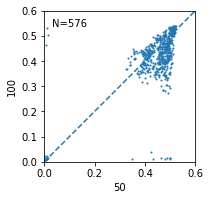

In [14]:
plot_scatter(df_to_use, 50, 100, 'input_size', '50', '100', 'input_size')

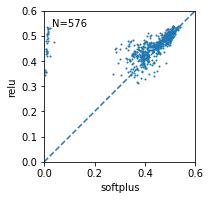

In [15]:
plot_scatter(df_to_use, 'softplus', 'relu', 'act_fn', 'softplus', 'relu', 'act')

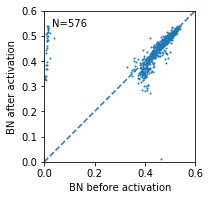

In [16]:
plot_scatter(df_to_use, True, False, 'bn_before_act', 'BN before activation', 'BN after activation', 'bn_before_act')
# pick BN before activation, ignore those outliers.

# outliers are all due to softplus. check line `df_to_use = df_to_use.xs('relu', level='act_fn')`.

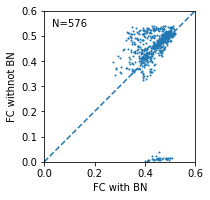

In [17]:
plot_scatter(df_to_use, True, False, 'bn_after_fc', 'FC with BN', 'FC withnot BN', 'bn_after_fc')
# pick FC without BN, ignore those outliers.

# outliers are all due to softplus. check line `df_to_use = df_to_use.xs('relu', level='act_fn')`.

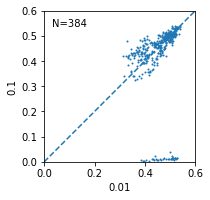

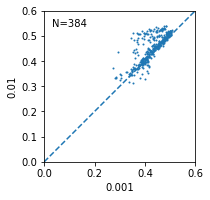

In [18]:
# scale
# no need to be shown in the paper.
plot_scatter(df_to_use, 0.01, 0.1, 'scale', '0.01', '0.1', 'scale_0p1_vs_0p01')  # similar.
plot_scatter(df_to_use, 0.001, 0.01, 'scale', '0.001', '0.01', 'scale_0p01_vs_0p001')  # 0.01 is better.

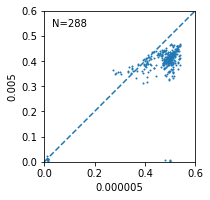

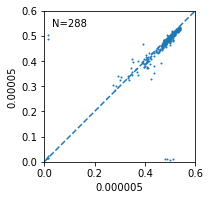

In [19]:
# smoothness has been examined before. no need to show everything. here I just show an example.


plot_scatter(df_to_use, 0.000005, 0.005, 'smoothness', '0.000005', '0.005', 'smooth_0p005_vs_0p000005')  # 0.01 is better.


plot_scatter(df_to_use, 0.000005, 0.00005, 'smoothness', '0.000005', '0.00005', 'smooth_0p00005_vs_0p000005')  # 0.01 is better.




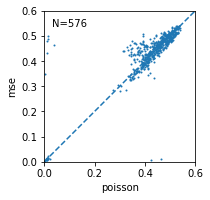

In [20]:
# loss_type
plot_scatter(df_to_use, 'poisson', 'mse', 'loss_type', 'poisson', 'mse', 'loss_type')


# outliers (those with ~0 performance points) are all due to softplus. check line `df_to_use = df_to_use.xs('relu', level='act_fn')`.